In [141]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray.plot as xplt
import cftime

In [142]:
import statsmodels.api as sm

In [143]:
import pysteps

In [144]:
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
platecarree = ccrs.PlateCarree()

In [156]:
gcmdata = xr.open_mfdataset("../../../data/60km/rcp85/01/*/day/*.nc")

In [164]:
cpmdata = xr.open_mfdataset("../../../data/2.2km/rcp85/01/pr/*.nc").rename({"pr": "target_pr"})
cpmdata = cpmdata.loc[dict(ensemble_member=1, time=slice("1980-12-01","1982-11-30"))]
cpmdata = cpmdata.reset_coords()[['target_pr']]
cpmdata

<xarray.Dataset>
Dimensions:         (grid_latitude: 606, grid_longitude: 484, time: 720)
Coordinates:
  * time            (time) object 1980-12-01 12:00:00 ... 1982-11-30 12:00:00
  * grid_latitude   (grid_latitude) float64 -4.683 -4.647 -4.611 ... 8.027 8.063
  * grid_longitude  (grid_longitude) float64 353.9 354.0 354.0 ... 364.3 364.3
Data variables:
    target_pr       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 606, 484), meta=np.ndarray>
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-07-30T06:13:12
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20190731
    Conventions:     CF-1.5

In [165]:
regridded_gcmdata = xr.open_mfdataset('../../../derived_data/60km/rcp85/01/*/day/*.nc')
regridded_gcmdata = regridded_gcmdata.loc[dict(ensemble_member=1, time=slice("1980-12-01","1982-11-30"))]
regridded_gcmdata = regridded_gcmdata.reset_coords()[['pr', 'psl']]
regridded_gcmdata

<xarray.Dataset>
Dimensions:         (grid_latitude: 606, grid_longitude: 484, time: 720)
Coordinates:
  * time            (time) object 1980-12-01 12:00:00 ... 1982-11-30 12:00:00
  * grid_latitude   (grid_latitude) float64 -4.683 -4.647 -4.611 ... 8.027 8.063
  * grid_longitude  (grid_longitude) float64 353.9 354.0 354.0 ... 364.3 364.3
Data variables:
    pr              (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(720, 606, 484), meta=np.ndarray>
    psl             (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(720, 606, 484), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [166]:
merged_data = xr.merge([regridded_gcmdata, cpmdata])
training_data = merged_data.sel({"time": slice("1980-12-01", "1981-11-30")}).isel(grid_latitude=100, grid_longitude=100)
test_data = merged_data.sel({"time": slice("1981-12-01", "1982-11-30")}).isel(grid_latitude=100, grid_longitude=100)

training_data

<xarray.Dataset>
Dimensions:         (time: 360)
Coordinates:
  * time            (time) object 1980-12-01 12:00:00 ... 1981-11-30 12:00:00
    grid_latitude   float64 -2.36
    grid_longitude  float64 356.3
Data variables:
    pr              (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    psl             (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    target_pr       (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [149]:
test_data

<xarray.Dataset>
Dimensions:         (time: 360)
Coordinates:
  * time            (time) object 1981-12-01 12:00:00 ... 1982-11-30 12:00:00
    grid_latitude   float64 -2.36
    grid_longitude  float64 356.3
Data variables:
    pr              (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    psl             (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    target_pr       (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [150]:
X = training_data[['pr', 'psl']].to_pandas()
X = sm.add_constant(X, prepend=False)
y = training_data[['target_pr']].to_pandas()
y['wetday'] = y['target_pr'] > 0.1

X_test = test_data[['pr', 'psl']].to_pandas()
X_test = sm.add_constant(X_test, prepend=False)
y_test = test_data[['target_pr']].to_pandas()
y_test['wetday'] = y_test['target_pr'] > 0.1

In [101]:
glm_binom = sm.GLM(y.wetday, X, family=sm.families.Binomial(sm.families.links.logit()))
glm_binom_results = glm_binom.fit()
print(glm_binom_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 wetday   No. Observations:                  360
Model:                            GLM   Df Residuals:                      357
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -152.61
Date:                Tue, 27 Jul 2021   Deviance:                       305.22
Time:                        11:49:56   Pearson chi2:                     464.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pr             0.8854      0.178      4.988      0.0

In [102]:
y_test_wet_pred = glm_binom_results.predict(X_test.values) > 0.5

In [104]:
glm_gamma = sm.GLM(y[y.wetday].target_pr, X[y.wetday], family=sm.families.Gamma(sm.families.links.log()))
glm_gamma_results = glm_gamma.fit()
print(glm_gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              target_pr   No. Observations:                  218
Model:                            GLM   Df Residuals:                      215
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                          1.6070
Method:                          IRLS   Log-Likelihood:                -539.60
Date:                Tue, 27 Jul 2021   Deviance:                       260.85
Time:                        11:50:32   Pearson chi2:                     346.
No. Iterations:                    29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pr             0.0962      0.013      7.350      0.0

In [105]:
y_test_pr_pred = glm_gamma_results.predict(X_test.values)

In [107]:
# for days predicted to be dry, set pr prediction to 0.0
y_test_pr_pred[1- y_test_wet_pred] = 0.0

In [114]:
pysteps.verification.detcontscores.det_cont_fct(y_test_pr_pred[y_test['wetday']], y_test[y_test['wetday']]['target_pr'].values, scores=['MAE'])

{'MAE': array(4.07790323)}

In [125]:
pysteps.verification.detcatscores.det_cat_fct(y_test_pr_pred[y_test['wetday']], y_test[y_test['wetday']]['target_pr'].values, scores=['CSI'], thr=0.4)

{'CSI': 0.8518518518518519}

In [124]:
pysteps.verification.detcatscores.det_cat_fct(y_test_pr_pred[y_test['wetday']], y_test[y_test['wetday']]['target_pr'].values, scores=['CSI'], thr=0.8)

{'CSI': 0.7129629629629629}

In [131]:
pysteps.verification.detcatscores.det_cat_fct(y_test_pr_pred[y_test['wetday']], y_test[y_test['wetday']]['target_pr'].values, scores=['CSI'], thr=20)

{'CSI': 0.16666666666666666}

(array([ 1., 25., 76., 33., 23., 12.,  8.,  7.,  6.,  5.,  6.,  2.,  1.,
         0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  2.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

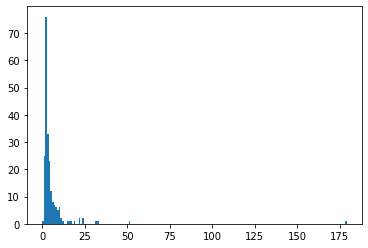

In [139]:
plt.hist(y_test_pr_pred[y_test['wetday']], bins='auto')

<AxesSubplot:>

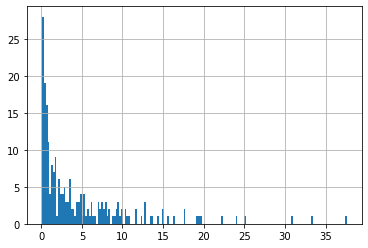

In [140]:
y_test[y_test['wetday']]['target_pr'].hist(bins=170)

## Groupby example

In [183]:
merged_data.isel({"grid_latitude": slice(10), "grid_longitude": slice(10)}).stack(gridcell=["grid_latitude", "grid_longitude"]).groupby("gridcell").mean(...).unstack("gridcell").target_pr.values

array([[1.771007 , 1.5863699, 1.6428552, 1.6351221, 1.6150781, 1.636189 ,
        1.696139 , 1.8188955, 1.8712367, 1.8308253],
       [1.7284445, 1.5256155, 1.5185044, 1.5206593, 1.5221899, 1.4737452,
        1.5453676, 1.6851542, 1.6409013, 1.575182 ],
       [1.7979387, 1.5489414, 1.4908407, 1.5004044, 1.4599645, 1.4481702,
        1.501079 , 1.7277937, 1.6114157, 1.5943973],
       [1.7715142, 1.5474786, 1.5019711, 1.4970984, 1.4673772, 1.4562802,
        1.5385609, 1.6993421, 1.6197165, 1.6367015],
       [1.7646427, 1.5539113, 1.4994696, 1.4604553, 1.4117591, 1.430789 ,
        1.5319608, 1.6281606, 1.5985867, 1.6456913],
       [1.8387126, 1.5926979, 1.5120336, 1.4587177, 1.4213803, 1.411058 ,
        1.501654 , 1.6254618, 1.6419556, 1.6658485],
       [1.948975 , 1.6611819, 1.5498333, 1.4957838, 1.4613827, 1.4516999,
        1.5223589, 1.6590947, 1.693477 , 1.688819 ],
       [2.080491 , 1.7415768, 1.6668385, 1.5445883, 1.5121359, 1.4991161,
        1.5668046, 1.5808343, 1.62063

In [186]:
merged_data.isel({"grid_latitude": 1, "grid_longitude": 2}).target_pr.mean().values

array(1.5185044, dtype=float32)